# Extracting Information from Financial News Descriptions with Classical NLP

In this notebook, we will explore how to extract meaningful information from news descriptions using **classical Natural Language Processing (NLP) tools**. More specifically, we will extract sentiment and company tickers (STOCK identifiers for companies found in the descriptions).
Ticker extration can be regarded as NER/NEL task.
We will use **Hugginface transformers library**.

---
- **Dataset**: https://www.kaggle.com/datasets/rdolphin/financial-news-with-ticker-level-sentiment/data?select=polygon_news_sample.json
- **Sentiment Analysis**: https://huggingface.co/yiyanghkust/finbert-tone
- **Ticker Extraction**: Regular expression. I tried with pre-trained NER models, but it does not detect the tickers.


In [1]:
import os
import json
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch
import re


/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-28 17:15:22.362505: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load dataset

In [28]:
# Load original dataset
DATA_DIR = '../data/polygon'
JSON_PATH = os.path.join(DATA_DIR, 'financial_news_with_ticker_level_sentiment.json')

with open(JSON_PATH, 'r') as f:
    data = json.load(f)

original_df = pd.DataFrame(data)


# Sentiment Analysis

## Load the pre-trained FinBERT model

In [3]:
# Load the pre-trained FinBERT model
finbert_model_name = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(finbert_model_name)
finbert = BertForSequenceClassification.from_pretrained(finbert_model_name)
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)


/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Tickers extraction

In [4]:
def extract_tickers(text):
    """Extract stock tickers from a given text."""
    tickers = re.findall(r'\b[A-Z]{2,5}\b', text)  # Regex for uppercase word (2-5 chars)
    return tickers


# Loop to extract sentiment and tickers

In [20]:
# Prepare the list for storing the extracted data
extracted_data = []

# Loop through the rows of the dataset
for index, row in df.iterrows():
    news_text = row['description']  # Assuming 'description' is the column with text
    
    # Extract sentiment using FinBERT
    sentiment_results = nlp(news_text)
    sentiment = sentiment_results[0]['entity']  # Extracting sentiment (POSITIVE/NEGATIVE/NEUTRAL)
    
    # Extract tickers using the function defined above
    tickers = extract_tickers(news_text)
    
    # Create the structured output
    extracted_data.append({
        "id": row['id'],  # Use the 'id' from the original dataset to link the data
        "description": news_text,
        "sentiment": sentiment,
        "tickers": tickers,
        #"author": row['author'],
        #"published_utc": row['published_utc'],
        #"publisher": row['publisher']
    })

# Convert the extracted data to a DataFrame
extracted_df = pd.DataFrame(extracted_data)

Traceback (most recent call last):
Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
  File "/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/my/vcxzmhpd1l1f6bhyh61p0qqh0000gn/T/ipykernel_4291/1468769994.py", line 9, in <module>
    sentiment_results = nlp(news_text)
                        ^^^^^^^^^^^^^^
  File "/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/lib/python3.12/site-packages/transformers/pipelines/token_classification.py", line 248, in __call__
    return super().__call__(inputs, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/lib/python3.12/site-packages/tran

In [21]:
extracted_df

id                                        description sentiment  \
0        0  Allegiant Travel (ALGT) is a fast-moving stock...  Negative   
1        1  Applied Industrial Technologies (AIT) reported...  Negative   
2        2  Apollo Commercial Real Estate Finance, Inc. (A...  Negative   
3        3  Maravai LifeSciences, a global provider of lif...  Negative   
4        4  DHT Holdings, an independent oil tanker compan...  Negative   
...    ...                                                ...       ...   
5543  5543  The article compares AT&T and Intel as potenti...   Neutral   
5544  5544  Zai Lab's new drug application for sulbactam-d...  Negative   
5545  5545  Terreno Realty is witnessing healthy demand fo...  Negative   
5546  5546  NextCure and Nordic Bioscience published a rev...  Negative   
5547  5547  Broadwind, Inc. announced that its stockholder...  Negative   

           tickers                  author         published_utc  \
0     [ALGT, ALGT]               Zacks.com  2023-06-29T12:50:06Z   
1            [AIT]               Zacks.com  2023-04-27T11:55:14Z   
2       [ARI, ARI]                     N/A  2023-03-06T13:30:00Z   
3       [CEO, CFO]                     N/A  2023-11-09T13:15:00Z   
4       [DHT, DHT]   Zacks Equity Research  2023-03-22T22:00:25Z   
...            ...                     ...                   ...   
5543          [AT]  Parkev Tatevosian, CFA  2023-01-30T14:38:04Z   
5544    [SUL, DUR]                     N/A  2023-01-30T12:30:00Z   
5545            []                     N/A  2023-01-24T15:19:00Z   
5546            []          NextCure, Inc.  2023-09-07T20:05:00Z   
5547            []                     N/A  2023-05-23T22:30:00Z   

                                              publisher  
0     {'name': 'Zacks Investment Research', 'homepag...  
1     {'name': 'Zacks Investment Research', 'homepag...  
2     {'name': 'GlobeNewswire Inc.', 'homepage_url':...  
3     {'name': 'GlobeNewswire Inc.', 'homepage_url':...  
4     {'name': 'Zacks Investment Research', 'homepag...  
...                                                 ...  
5543  {'name': 'The Motley Fool', 'homepage_url': 'h...  
5544  {'name': 'GlobeNewswire Inc.', 'homepage_url':...  
5545  {'name': 'Zacks Investment Research', 'homepag...  
5546  {'name': 'GlobeNewswire Inc.', 'homepage_url':...  
5547  {'name': 'GlobeNewswire Inc.', 'homepage_url':...  

[5548 rows x 7 columns]

In [24]:
extracted_df.drop(['author', 'published_utc', 'publisher'], axis=1,inplace=True)

In [26]:
extracted_df.columns

Index(['id', 'description', 'sentiment', 'tickers'], dtype='object')

## Save extracted data

In [25]:
# Save the extracted data to a JSON file for later evaluation
extracted_json_path = os.path.join(DATA_DIR, 'extracted_sentiment_and_tickers_finbert.json')
extracted_df.to_json(extracted_json_path, orient='records', lines=True)

print(f"Extracted data saved to {extracted_json_path}")

Extracted data saved to ../data/polygon/extracted_sentiment_and_tickers_finbert.json


# Evaluate extracted data

Since the new extraction approach assigns a single sentiment per news article, while the original dataset has sentiment per ticker, we need to compare them in a way that makes sense. 
Original Sentiment Averaging:

    Each news article in original_df has multiple tickers, each with its own sentiment.
    Convert "positive", "neutral", and "negative" to numeric values (1, 0, -1).
    Compute the average sentiment across tickers for each article.

In [47]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert sentiments in original dataset to numeric values
sentiment_mapping = {"positive": 1, "neutral": 0, "negative": -1}

# Extract and average sentiments for each article in original_df
def average_original_sentiment(row):
    sentiments = [sentiment_mapping.get(insight["sentiment"], np.nan) for insight in row["insights"]]
    return np.nanmean(sentiments) if sentiments else np.nan  # Avoid empty lists

original_df["avg_sentiment"] = original_df.apply(average_original_sentiment, axis=1)

# Map extracted_df sentiments to numeric values
extracted_df["sentiment_numeric"] = extracted_df['sentiment'].apply(lambda x: x.lower())
extracted_df["sentiment_numeric"]= extracted_df["sentiment_numeric"].map(sentiment_mapping)

/var/folders/my/vcxzmhpd1l1f6bhyh61p0qqh0000gn/T/ipykernel_4291/4030117785.py:12: RuntimeWarning: Mean of empty slice
  return np.nanmean(sentiments) if sentiments else np.nan  # Avoid empty lists


📊 Sentiment Correlation: -0.04


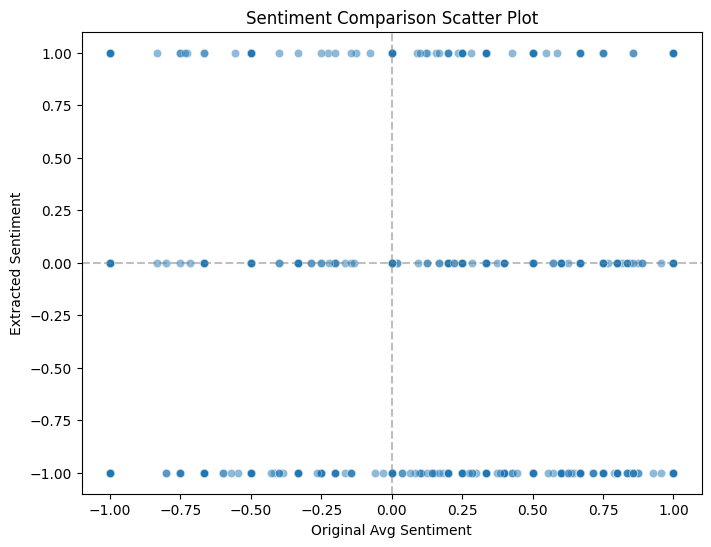

In [48]:
# Merge both datasets on 'id'
comparison_df = original_df[["id", "avg_sentiment"]].merge(
    extracted_df[["id", "sentiment_numeric"]], on="id", how="inner"
)

# Drop NaNs (if any)
comparison_df = comparison_df.dropna()

# Compute correlation between extracted and original sentiments
correlation = np.corrcoef(comparison_df["avg_sentiment"], comparison_df["sentiment_numeric"])[0, 1]
print(f"📊 Sentiment Correlation: {correlation:.2f}")

# Plot a scatter plot to visualize sentiment agreement
plt.figure(figsize=(8, 6))
sns.scatterplot(x=comparison_df["avg_sentiment"], y=comparison_df["sentiment_numeric"], alpha=0.5)
plt.xlabel("Original Avg Sentiment")
plt.ylabel("Extracted Sentiment")
plt.title("Sentiment Comparison Scatter Plot")
plt.axhline(0, color="gray", linestyle="--", alpha=0.5)
plt.axvline(0, color="gray", linestyle="--", alpha=0.5)
plt.show()



## Sentiment Classification Report

In [49]:
# Print classification report after rounding original sentiments
comparison_df["rounded_original_sentiment"] = comparison_df["avg_sentiment"].round().astype(int)
print("\n📊 **Sentiment Classification Report:**")
print(classification_report(comparison_df["rounded_original_sentiment"], comparison_df["sentiment_numeric"], zero_division=0))




📊 **Sentiment Classification Report:**
              precision    recall  f1-score   support

          -1       0.07      0.62      0.13       425
           0       0.32      0.26      0.28      1903
           1       0.47      0.08      0.13      3217

    accuracy                           0.18      5545
   macro avg       0.29      0.32      0.18      5545
weighted avg       0.39      0.18      0.18      5545



In [59]:
## Ticker Extraction Performance

📊 **Ticker Extraction Performance:**
✅ Average Precision: 0.25
✅ Average Recall: 0.24
✅ Average F1-score: 0.23


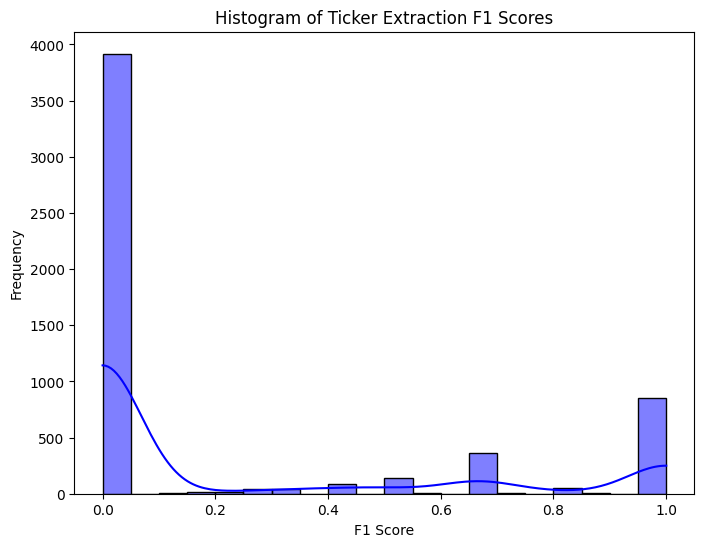

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure tickers are uppercase and stored as sets
original_df["tickers_set"] = original_df["tickers"].apply(lambda x: set(map(str.upper, x)) if isinstance(x, list) else set())
extracted_df["tickers_set"] = extracted_df["tickers"].apply(lambda x: set(map(str.upper, x)) if isinstance(x, list) else set())

# Merge the datasets on 'id'
comparison_df = original_df[["id", "tickers_set"]].merge(
    extracted_df[["id", "tickers_set"]], on="id", how="inner"
)

# Compute precision, recall, and F1-score per row
def compute_ticker_metrics(row):
    original_tickers = row["tickers_set_x"]
    extracted_tickers = row["tickers_set_y"]  # From extracted_df
    
    if not original_tickers and not extracted_tickers:
        return (1, 1, 1)  # If both are empty, perfect match
    
    if not extracted_tickers:
        return (0, 0, 0)  # No tickers found in extraction
    
    true_positives = len(original_tickers & extracted_tickers)  # Correctly matched tickers
    precision = true_positives / len(extracted_tickers) if extracted_tickers else 0
    recall = true_positives / len(original_tickers) if original_tickers else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return (precision, recall, f1)

# Apply metric calculation
comparison_df[["precision", "recall", "f1"]] = comparison_df.apply(compute_ticker_metrics, axis=1, result_type="expand")

# Compute overall average scores
avg_precision = comparison_df["precision"].mean()
avg_recall = comparison_df["recall"].mean()
avg_f1 = comparison_df["f1"].mean()

print(f"📊 **Ticker Extraction Performance:**")
print(f"✅ Average Precision: {avg_precision:.2f}")
print(f"✅ Average Recall: {avg_recall:.2f}")
print(f"✅ Average F1-score: {avg_f1:.2f}")

# Plot a histogram of per-article F1 scores
plt.figure(figsize=(8, 6))
sns.histplot(comparison_df["f1"], bins=20, kde=True, color="blue")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.title("Histogram of Ticker Extraction F1 Scores")
plt.show()
